## Import the necessary libraries

In [142]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
from scipy.signal.windows import hann
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [143]:
# Load and preprocess data
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\DHT Historical Data.csv')
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [144]:
# Select 'Price' column and handle missing values
price_data = df['Price'].astype(float).interpolate()

In [145]:
# Remove outliers (simple Z-score method)
z_scores = np.abs((price_data - price_data.mean()) / price_data.std())
price_data = price_data[z_scores < 3]

In [146]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(price_data.values.reshape(-1, 1))

In [147]:
# Split data
train_size = int(len(data_scaled) * 0.7)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:train_size + len(df.index) - train_size]



In [148]:
# Perform FFT with windowing
def fft_transform(data, num_frequencies=10):
    n = len(data)
    window = hann(n)
    fft_result = fft(data * window)
    frequencies = np.fft.fftfreq(n)
    
    # Keep only top frequencies
    top_indices = np.argsort(np.abs(fft_result))[-num_frequencies:]
    filtered_fft = np.zeros_like(fft_result)
    filtered_fft[top_indices] = fft_result[top_indices]
    
    return filtered_fft, frequencies



In [149]:
# Inverse FFT
def ifft_transform(fft_result):
    return np.real(ifft(fft_result))

In [150]:
# Modify predict_with_trend function
def predict_with_trend(data, fft_result, days, window_size=30):
    # Linear trend
    x = np.arange(window_size)
    trend = np.polyfit(x, data[-window_size:].flatten(), 1)
    trend_func = np.poly1d(trend)
    
    # FFT prediction
    n = len(data)
    if len(fft_result) != n:
        fft_result, _ = fft_transform(data.flatten(), num_frequencies=best_num_freq)
    
    extended_fft = np.zeros(window_size + days, dtype=complex)
    extended_fft[:window_size] = fft_result[-window_size:]
    fft_pred = ifft_transform(extended_fft)[-days:]
    
    # Combine trend and FFT
    trend_pred = trend_func(np.arange(window_size, window_size+days))
    combined_pred = trend_pred + fft_pred
    return np.maximum(combined_pred, 0)  # Ensure non-negative values

In [151]:
# Optimize number of frequencies
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_num_freq = 0

for num_freq in range(5, 51, 5):
    mse_scores = []
    for train_index, val_index in tscv.split(train_data):
        train_subset = train_data[train_index]
        val_subset = train_data[val_index]
        
        train_fft, _ = fft_transform(train_subset.flatten(), num_frequencies=num_freq)
        pred = predict_with_trend(train_subset, train_fft, len(val_subset))
        mse = mean_squared_error(val_subset, pred)
        mse_scores.append(mse)
    
    avg_mse = np.mean(mse_scores)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_num_freq = num_freq

print(f"Best number of frequencies: {best_num_freq}")


Best number of frequencies: 5


In [152]:
# Recompute FFT with best number of frequencies
train_fft, _ = fft_transform(train_data.flatten(), num_frequencies=best_num_freq)

In [153]:
# Predict for test data using sliding window
window_size = 30
step_size = 7
filtered_test = []

for i in range(0, len(test_data), step_size):
    if i + window_size > len(train_data):
        break
    window_data = np.concatenate((train_data[-window_size:], test_data[:i]))
    window_fft, _ = fft_transform(window_data.flatten(), num_frequencies=best_num_freq)
    pred = predict_with_trend(window_data, window_fft, step_size, window_size)
    filtered_test.extend(pred)

filtered_test = np.array(filtered_test)[:len(test_data)]

In [154]:
# Predict future values
future_data = np.concatenate((train_data, test_data))
future_fft, _ = fft_transform(future_data.flatten(), num_frequencies=best_num_freq)
y_next_30_days = predict_with_trend(future_data, future_fft, 30, window_size)
y_next_60_days = predict_with_trend(future_data, future_fft, 60, window_size)
y_next_90_days = predict_with_trend(future_data, future_fft, 90, window_size)

In [155]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(test_data, filtered_test.reshape(-1, 1))
test_mse = mean_squared_error(test_data, filtered_test.reshape(-1, 1))
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data, filtered_test.reshape(-1, 1))

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 0.6388880348668309
RMSE on Test set: 0.5714126112261264
MSLE on Test set: 0.08712440568362066


In [156]:
# Inverse transform predictions
filtered_test = scaler.inverse_transform(filtered_test.reshape(-1, 1)).flatten()
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(y_next_60_days.reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1)).flatten()

# Print predictions
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

Predicted next 30 days:
[63377.13991267  9384.         56203.34271248  9384.
 48427.14224588 13862.49607098 40949.54031904 21265.42531481
 34461.13855288 27443.58805409 29350.37852229 32176.21600977
 25669.75861346 35571.83133039 23164.41006094 38010.30104742
 21356.44546994 40036.21820858 19668.73479528 42223.83417682
 17564.90855578 45038.6841684  14679.62299095 48721.54026675
 10914.9232395  53216.31127098  9384.         58155.6877686
  9384.         62908.06578786]

Predicted next 60 days:
[51368.81644944  9384.         30976.85779219 56063.86053453
  9384.         23301.05222334 58524.81234449 10745.95739725
 16534.20922407 58683.33910147 17928.57816965 11270.7241818
 56749.14413141 25302.51826634  9384.         53165.33341848
 32171.8277512   9384.         48529.03851083 37984.86642903
  9384.         43491.14142557 42403.87488194  9384.
 38652.31003348 45336.19815288 11449.92243793 34472.94541518
 46922.9510261  14618.3078323  31212.00862059 47488.28035174
 17706.3704678  28904.

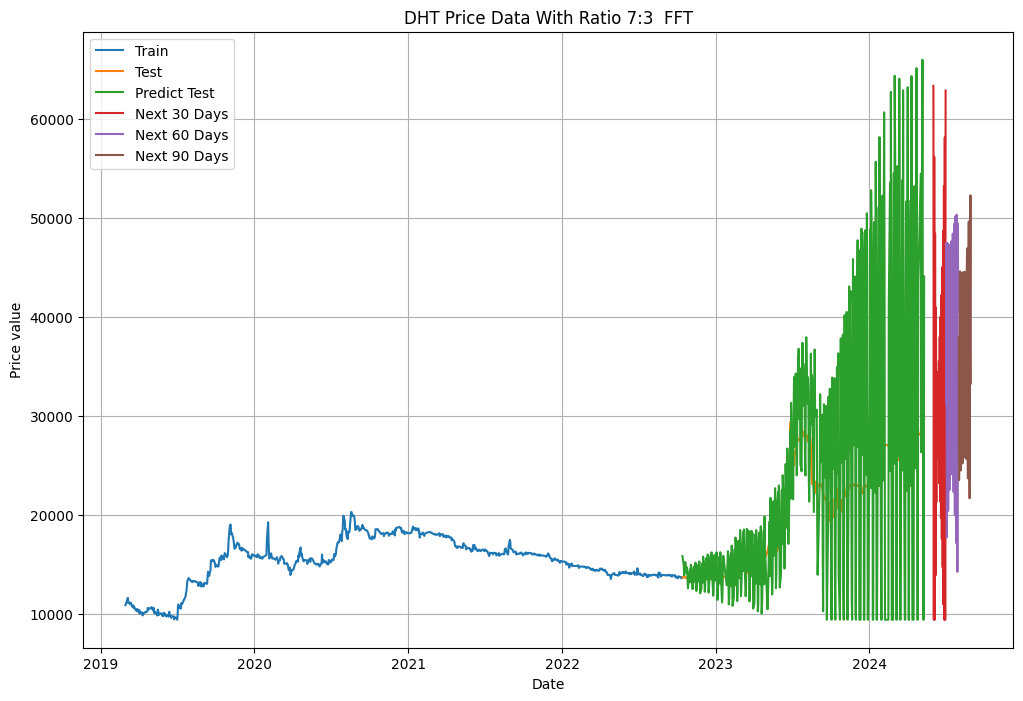

In [157]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), index=df.index[train_size:train_size+len(test_data)], columns=['Price'])
filtered_test_df = pd.DataFrame(filtered_test, index=df.index[train_size:train_size+len(filtered_test)], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(filtered_test_df.index, filtered_test_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("DHT Price Data With Ratio 7:3  FFT")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('FFT_73_DHT.png')
plt.show()

## Model 8:2

In [158]:
# Load and preprocess data
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\DHT Historical Data.csv')
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [159]:
# Select 'Price' column and handle missing values
price_data = df['Price'].astype(float).interpolate()

In [160]:
# Remove outliers (simple Z-score method)
z_scores = np.abs((price_data - price_data.mean()) / price_data.std())
price_data = price_data[z_scores < 3]

In [161]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(price_data.values.reshape(-1, 1))

In [162]:
# Split data
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [163]:
# Perform FFT with windowing
def fft_transform(data, num_frequencies=10):
    n = len(data)
    window = hann(n)
    fft_result = fft(data * window)
    frequencies = np.fft.fftfreq(n)
    
    # Keep only top frequencies
    top_indices = np.argsort(np.abs(fft_result))[-num_frequencies:]
    filtered_fft = np.zeros_like(fft_result)
    filtered_fft[top_indices] = fft_result[top_indices]
    
    return filtered_fft, frequencies


In [164]:
# Inverse FFT
def ifft_transform(fft_result):
    return np.real(ifft(fft_result))

In [165]:
# Modify predict_with_trend function
def predict_with_trend(data, fft_result, days, window_size=30):
    # Linear trend
    x = np.arange(window_size)
    trend = np.polyfit(x, data[-window_size:].flatten(), 1)
    trend_func = np.poly1d(trend)
    
    # FFT prediction
    n = len(data)
    if len(fft_result) != n:
        fft_result, _ = fft_transform(data.flatten(), num_frequencies=best_num_freq)
    
    extended_fft = np.zeros(window_size + days, dtype=complex)
    extended_fft[:window_size] = fft_result[-window_size:]
    fft_pred = ifft_transform(extended_fft)[-days:]
    
    # Combine trend and FFT
    trend_pred = trend_func(np.arange(window_size, window_size+days))
    combined_pred = trend_pred + fft_pred
    return np.maximum(combined_pred, 0)  # Ensure non-negative values

In [166]:
# Optimize number of frequencies
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_num_freq = 0

for num_freq in range(5, 51, 5):
    mse_scores = []
    for train_index, val_index in tscv.split(train_data):
        train_subset = train_data[train_index]
        val_subset = train_data[val_index]
        
        train_fft, _ = fft_transform(train_subset.flatten(), num_frequencies=num_freq)
        pred = predict_with_trend(train_subset, train_fft, len(val_subset))
        mse = mean_squared_error(val_subset, pred)
        mse_scores.append(mse)
    
    avg_mse = np.mean(mse_scores)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_num_freq = num_freq

print(f"Best number of frequencies: {best_num_freq}")


Best number of frequencies: 5


In [167]:
# Recompute FFT with best number of frequencies
train_fft, _ = fft_transform(train_data.flatten(), num_frequencies=best_num_freq)

In [168]:
# Predict for test data using sliding window
window_size = 30
step_size = 7
filtered_test = []

for i in range(0, len(test_data), step_size):
    if i + window_size > len(train_data):
        break
    window_data = np.concatenate((train_data[-window_size:], test_data[:i]))
    window_fft, _ = fft_transform(window_data.flatten(), num_frequencies=best_num_freq)
    pred = predict_with_trend(window_data, window_fft, step_size, window_size)
    filtered_test.extend(pred)

filtered_test = np.array(filtered_test)[:len(test_data)]

In [169]:
# Predict future values
future_data = np.concatenate((train_data, test_data))
future_fft, _ = fft_transform(future_data.flatten(), num_frequencies=best_num_freq)
y_next_30_days = predict_with_trend(future_data, future_fft, 30, window_size)
y_next_60_days = predict_with_trend(future_data, future_fft, 60, window_size)
y_next_90_days = predict_with_trend(future_data, future_fft, 90, window_size)

In [170]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(test_data, filtered_test.reshape(-1, 1))
test_mse = mean_squared_error(test_data, filtered_test.reshape(-1, 1))
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data, filtered_test.reshape(-1, 1))

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 0.5793246240279935
RMSE on Test set: 0.5188956117640924
MSLE on Test set: 0.08622927867019073


In [171]:
# Inverse transform predictions
filtered_test = scaler.inverse_transform(filtered_test.reshape(-1, 1)).flatten()
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(y_next_60_days.reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1)).flatten()

# Print predictions
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

Predicted next 30 days:
[63377.13991267  9384.         56203.34271248  9384.
 48427.14224588 13862.49607098 40949.54031904 21265.42531481
 34461.13855288 27443.58805409 29350.37852229 32176.21600977
 25669.75861346 35571.83133039 23164.41006094 38010.30104742
 21356.44546994 40036.21820858 19668.73479528 42223.83417682
 17564.90855578 45038.6841684  14679.62299095 48721.54026675
 10914.9232395  53216.31127098  9384.         58155.6877686
  9384.         62908.06578786]

Predicted next 60 days:
[51368.81644944  9384.         30976.85779219 56063.86053453
  9384.         23301.05222334 58524.81234449 10745.95739725
 16534.20922407 58683.33910147 17928.57816965 11270.7241818
 56749.14413141 25302.51826634  9384.         53165.33341848
 32171.8277512   9384.         48529.03851083 37984.86642903
  9384.         43491.14142557 42403.87488194  9384.
 38652.31003348 45336.19815288 11449.92243793 34472.94541518
 46922.9510261  14618.3078323  31212.00862059 47488.28035174
 17706.3704678  28904.

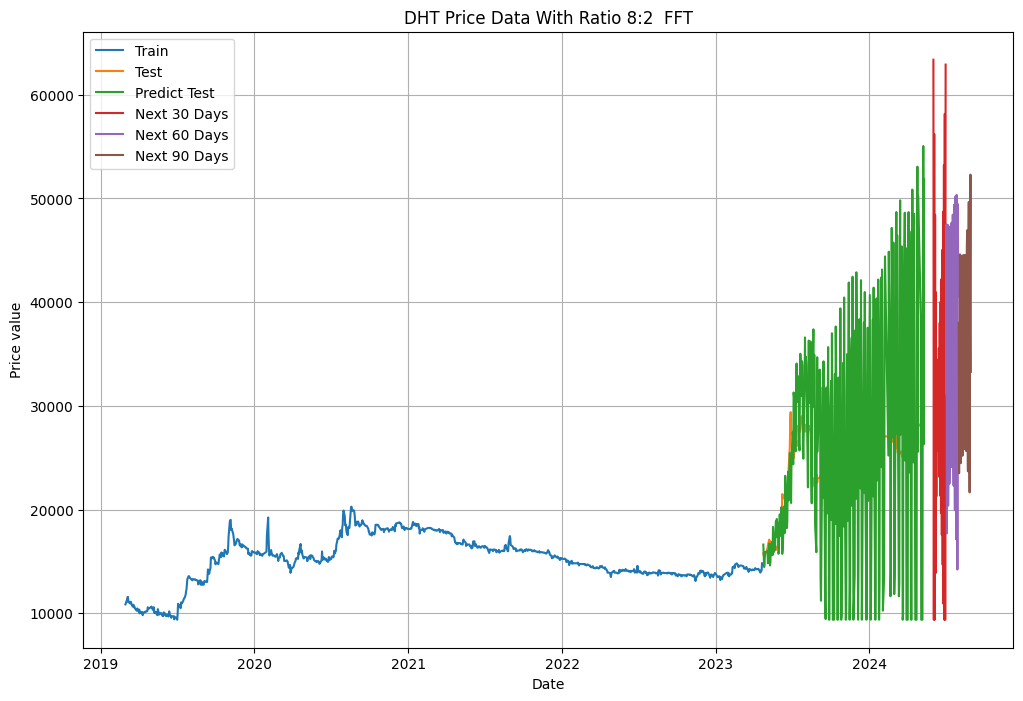

In [172]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), index=df.index[train_size:train_size+len(test_data)], columns=['Price'])
filtered_test_df = pd.DataFrame(filtered_test, index=df.index[train_size:train_size+len(filtered_test)], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(filtered_test_df.index, filtered_test_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("DHT Price Data With Ratio 8:2  FFT")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('FFT_82_DHT.png')
plt.show()

## Model 9:1

In [173]:
# Load and preprocess data
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\DHT Historical Data.csv')
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [174]:
# Select 'Price' column and handle missing values
price_data = df['Price'].astype(float).interpolate()

In [175]:
# Remove outliers (simple Z-score method)
z_scores = np.abs((price_data - price_data.mean()) / price_data.std())
price_data = price_data[z_scores < 3]

In [176]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(price_data.values.reshape(-1, 1))

In [177]:
# Split data
train_size = int(len(data_scaled) * 0.9)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [178]:
# Perform FFT with windowing
def fft_transform(data, num_frequencies=10):
    n = len(data)
    window = hann(n)
    fft_result = fft(data * window)
    frequencies = np.fft.fftfreq(n)
    
    # Keep only top frequencies
    top_indices = np.argsort(np.abs(fft_result))[-num_frequencies:]
    filtered_fft = np.zeros_like(fft_result)
    filtered_fft[top_indices] = fft_result[top_indices]
    
    return filtered_fft, frequencies


In [179]:
# Inverse FFT
def ifft_transform(fft_result):
    return np.real(ifft(fft_result))

In [180]:
# Modify predict_with_trend function
def predict_with_trend(data, fft_result, days, window_size=30):
    # Linear trend
    x = np.arange(window_size)
    trend = np.polyfit(x, data[-window_size:].flatten(), 1)
    trend_func = np.poly1d(trend)
    
    # FFT prediction
    n = len(data)
    if len(fft_result) != n:
        fft_result, _ = fft_transform(data.flatten(), num_frequencies=best_num_freq)
    
    extended_fft = np.zeros(window_size + days, dtype=complex)
    extended_fft[:window_size] = fft_result[-window_size:]
    fft_pred = ifft_transform(extended_fft)[-days:]
    
    # Combine trend and FFT
    trend_pred = trend_func(np.arange(window_size, window_size+days))
    combined_pred = trend_pred + fft_pred
    return np.maximum(combined_pred, 0)  # Ensure non-negative values

In [181]:
# Optimize number of frequencies
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_num_freq = 0

for num_freq in range(5, 51, 5):
    mse_scores = []
    for train_index, val_index in tscv.split(train_data):
        train_subset = train_data[train_index]
        val_subset = train_data[val_index]
        
        train_fft, _ = fft_transform(train_subset.flatten(), num_frequencies=num_freq)
        pred = predict_with_trend(train_subset, train_fft, len(val_subset))
        mse = mean_squared_error(val_subset, pred)
        mse_scores.append(mse)
    
    avg_mse = np.mean(mse_scores)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_num_freq = num_freq

print(f"Best number of frequencies: {best_num_freq}")


Best number of frequencies: 5


In [182]:
# Recompute FFT with best number of frequencies
train_fft, _ = fft_transform(train_data.flatten(), num_frequencies=best_num_freq)

In [183]:
# Predict for test data using sliding window
window_size = 30
step_size = 7
filtered_test = []

for i in range(0, len(test_data), step_size):
    if i + window_size > len(train_data):
        break
    window_data = np.concatenate((train_data[-window_size:], test_data[:i]))
    window_fft, _ = fft_transform(window_data.flatten(), num_frequencies=best_num_freq)
    pred = predict_with_trend(window_data, window_fft, step_size, window_size)
    filtered_test.extend(pred)

filtered_test = np.array(filtered_test)[:len(test_data)]

In [184]:
# Predict future values
future_data = np.concatenate((train_data, test_data))
future_fft, _ = fft_transform(future_data.flatten(), num_frequencies=best_num_freq)
y_next_30_days = predict_with_trend(future_data, future_fft, 30, window_size)
y_next_60_days = predict_with_trend(future_data, future_fft, 60, window_size)
y_next_90_days = predict_with_trend(future_data, future_fft, 90, window_size)

In [185]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(test_data, filtered_test.reshape(-1, 1))
test_mse = mean_squared_error(test_data, filtered_test.reshape(-1, 1))
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data, filtered_test.reshape(-1, 1))

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 0.34962492373617177
RMSE on Test set: 0.3351384422342631
MSLE on Test set: 0.03354335382746665


In [186]:
# Inverse transform predictions
filtered_test = scaler.inverse_transform(filtered_test.reshape(-1, 1)).flatten()
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(y_next_60_days.reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1)).flatten()

# Print predictions
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

Predicted next 30 days:
[63377.13991267  9384.         56203.34271248  9384.
 48427.14224588 13862.49607098 40949.54031904 21265.42531481
 34461.13855288 27443.58805409 29350.37852229 32176.21600977
 25669.75861346 35571.83133039 23164.41006094 38010.30104742
 21356.44546994 40036.21820858 19668.73479528 42223.83417682
 17564.90855578 45038.6841684  14679.62299095 48721.54026675
 10914.9232395  53216.31127098  9384.         58155.6877686
  9384.         62908.06578786]

Predicted next 60 days:
[51368.81644944  9384.         30976.85779219 56063.86053453
  9384.         23301.05222334 58524.81234449 10745.95739725
 16534.20922407 58683.33910147 17928.57816965 11270.7241818
 56749.14413141 25302.51826634  9384.         53165.33341848
 32171.8277512   9384.         48529.03851083 37984.86642903
  9384.         43491.14142557 42403.87488194  9384.
 38652.31003348 45336.19815288 11449.92243793 34472.94541518
 46922.9510261  14618.3078323  31212.00862059 47488.28035174
 17706.3704678  28904.

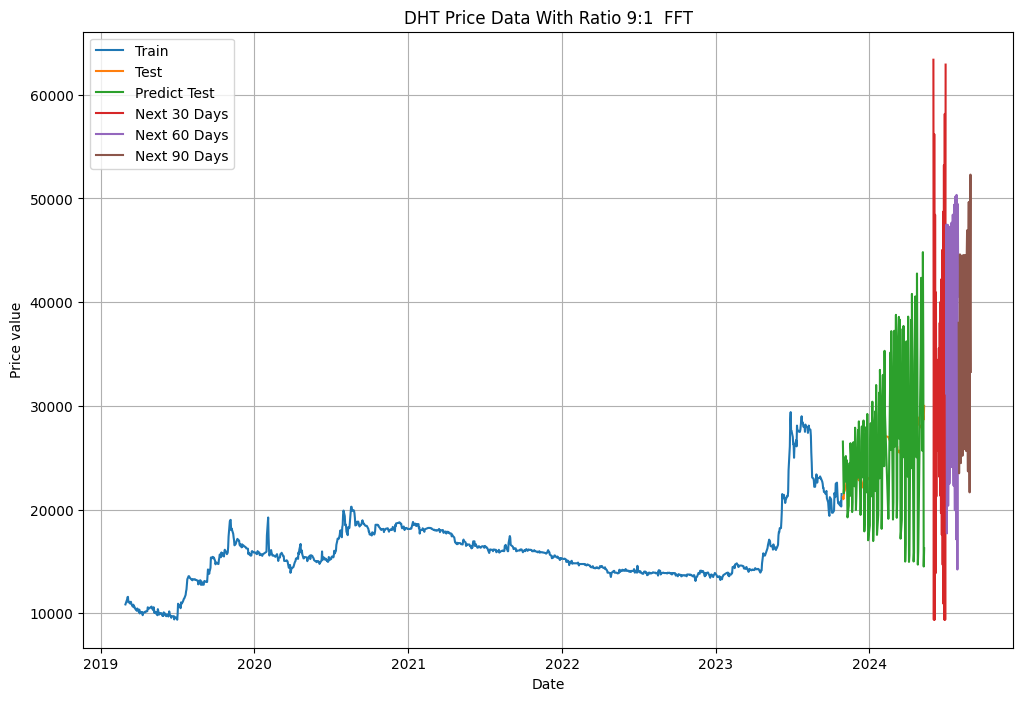

In [187]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), index=df.index[train_size:train_size+len(test_data)], columns=['Price'])
filtered_test_df = pd.DataFrame(filtered_test, index=df.index[train_size:train_size+len(filtered_test)], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(filtered_test_df.index, filtered_test_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("DHT Price Data With Ratio 9:1  FFT")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('FFT_91_DHT.png')
plt.show()